# Modeling
- viral features : 'youtube_view_mean', 'comment_count', 'abs_mean_square','actor_power'

> Modeling
1. viral features 제외한 피쳐들로 모델링, 예측 후 잔차 추출
2. 잔차를 종속변수로 사용해서 viral features로 예측
3. scaling 해서 index 생성

# Viral Index

## import

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.linear_model import ElasticNet, ElasticNetCV # 두 개 구분
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn import preprocessing
import xgboost as xgb
import lightgbm as lgb

%matplotlib inline
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

## Data

In [2]:
data = pd.read_excel('data/Movie_Data_Final_transformation.xlsx').iloc[:,1:]

# modeling에 포함되지 않는 columns 제거
colums_rm = ['movie_name','release', 'take', 'code', 'kind', 'scale', 'actor']
def remove_columns(movie_df):
    col = list(movie_df.columns)
    for i in colums_rm:
        col.remove(i)
    movie_df = movie_df.loc[:, col]
    
    return movie_df

# 영화명 날림
data = remove_columns(data)

In [3]:
data = data[['audience', 'log_youtube_view_mean', 'sqrt_comment_count','sqrt_abs_mean_score',
             'sqrt_actor_power', 'nation', 'distribution_company', 'genre', 'running_time','age']]

In [4]:
data = pd.get_dummies(data = data, columns = ['nation'], prefix = 'nation')
data = pd.get_dummies(data = data, columns = ['distribution_company'], prefix = 'distribution_company')
data = pd.get_dummies(data = data, columns = ['genre'], prefix = 'genre')
data = pd.get_dummies(data = data, columns = ['age'], prefix = 'age')

x = data.iloc[:,1:] 
y = np.log(data.iloc[:,0]) # 관객수 log transformation


x_viral = x.iloc[:,:4] # viral 관련 Feature
x_movie = x.iloc[:,4:] # movie 관련 Feature

## modeling

### 1st Model : about movie Features

In [5]:
# Test set, Train set 분리

x_movie_train, x_movie_test, y_movie_train, y_movie_test = train_test_split(x_movie, y, test_size=0.2, random_state=0)

#### hyperparameter

In [6]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100,
                  200,
                  300,
                  400,
                  500,
                  600,
                  700,
                  800,
                  900,
                  1000,
                  1100,
                  1200,
                  1300,
                  1400,
                  1500,
                  1600,
                  1700,
                  1800,
                  1900,
                  2000]}


In [8]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
randomforest = RandomForestRegressor(random_state=0)

rf_random = RandomizedSearchCV(estimator = randomforest,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(x_movie_train, y_movie_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.7min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100, 1200,
                                                         1300, 1400, 1500, 1600,
                                                         1700, 1800,

In [9]:
# best match 출력

rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [11]:
# Random CV 결과

ypred_rf_random = rf_random.predict(x_movie_test)
mse_rf_random = mean_squared_error(y_movie_test, ypred_rf_random)
R2_score = r2_score(y_movie_test, ypred_rf_random)

print('MSE : {:.2f} RMSE : {:.2f} R2 : {:.2f}'.format(mse_rf_random, np.sqrt(mse_rf_random), R2_score))

MSE : 0.84 RMSE : 0.92 R2 : 0.11


In [12]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy),'\n')
    
    return accuracy

In [13]:
# Random CV로 정한 모델과 오리지날 모델 정확도 비교

print("Basic Model")
base_model = randomforest
base_model.fit(x_movie_train, y_movie_train)
base_accuracy = evaluate(base_model, x_movie_test, y_movie_test)

print("Random CV Model")
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, x_movie_test, y_movie_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Basic Model
Model Performance
Average Error: 0.8233 degrees.
Accuracy = 94.13%. 

Random CV Model
Model Performance
Average Error: 0.6971 degrees.
Accuracy = 95.02%. 

Improvement of 0.94%.


#### fit model

In [14]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [21]:
rf = RandomForestRegressor(n_estimators= 800,
                           min_samples_split= 2,
                           min_samples_leaf=4, 
                           max_features= 'sqrt', 
                           max_depth= 30, 
                           bootstrap= True,
                           random_state = 0)

rf.fit(x_movie, y)
y_movie_pred = rf.predict(x_movie)

# model fit 시킨 data로 prediction해서 over fitting(과적합) 걱정됌

importance = rf.feature_importances_

In [23]:
y_hat = y-y_movie_pred
y_hat

0      1.464014
1      2.213772
2      0.915259
3      1.033630
4      1.168774
         ...   
185   -1.923567
186   -2.119940
187   -2.113241
188   -1.870529
189   -2.069828
Name: audience, Length: 190, dtype: float64

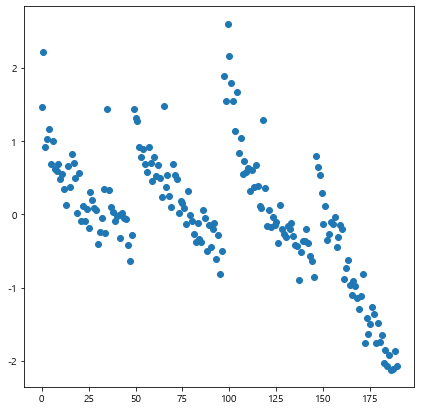

In [38]:
plt.figure(figsize = (7,7))
plt.scatter(y_hat.index,y_hat)  # 잔차 그래프가 매우 상관성이 있어보인다..!
                                # 그룹 4개 상위 50개 4개년이라 그룹 형성!
plt.show()

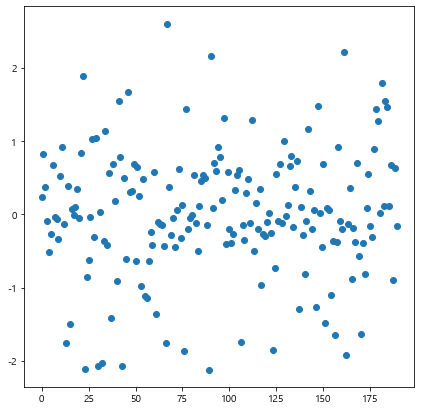

In [100]:
import random 

plt.figure(figsize = (7,7))
plt.scatter(range(len(y_hat)),random.sample(list(y_hat),len(y_hat)))  
plt.show() # 순서 랜덤으로 하니 괜찮은 잔차 plot..!

Feature ranking
1. feature running_time (0.379)
2. feature distribution_company_(주)씨제이이엔엠 (0.086)
3. feature distribution_company_월트디즈니컴퍼니코리아 유한책임회사 (0.053)
4. feature genre_액션 (0.040)
5. feature distribution_company_워너브러더스 코리아(주) (0.037)
6. feature genre_드라마 (0.034)
7. feature distribution_company_(주)에이스메이커무비웍스 (0.033)
8. feature age_15세이상관람가 (0.030)
9. feature age_12세이상관람가 (0.027)
10. feature nation_한국 (0.025)


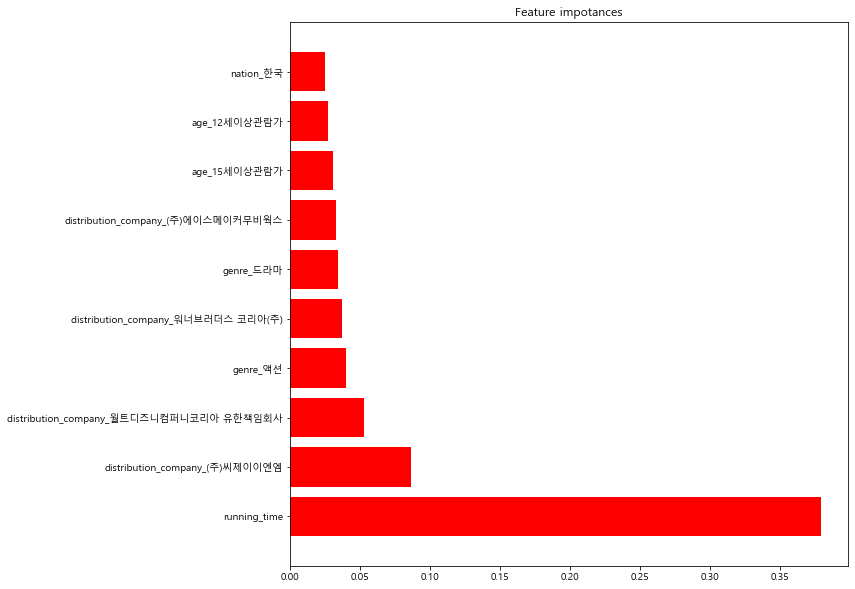

In [25]:
indices = np.argsort(importance)[::-1]

# print the feature ranking
print("Feature ranking")

# 상위 10개만
for f in range(10):
    print("{}. feature {} ({:.3f})".format(f+1, x_movie.columns[indices][f], importance[indices[f]]))
    
# Plot the imprity-based feature importances of the forest
plt.figure(figsize=(10,10))
plt.title("Feature impotances")
plt.barh(range(x_movie.shape[1])[:10], importance[indices][:10], color = 'r')
plt.yticks(range(x_movie.shape[1])[:10], x_movie.columns[indices][:10])
plt.ylim([-1, 10])
plt.show()

### 2nd Model : about viral features

In [60]:
# 단위가 다르니 정규화 후 모델링
# Normalize Data
x_norm = x_viral

std_scale = preprocessing.StandardScaler().fit(x_norm)
x_viral_norm = std_scale.transform(x_norm)

#Converting numpy array to dataframe
x_norm_col = pd.DataFrame(x_viral_norm, index=x_norm.index, columns=x_norm.columns) 
x_viral.update(x_norm_col)
print (x_viral.head())

   log_youtube_view_mean  sqrt_comment_count  sqrt_abs_mean_score  \
0               0.607924            0.299134             0.585738   
1               0.876235            1.668276            -0.873243   
2               1.100347           -1.078816            -0.948748   
3               1.409522            0.694220            -1.137865   
4               1.422851           -0.442221            -0.598667   

   sqrt_actor_power  
0          2.896179  
1          2.030635  
2          1.351458  
3          2.023730  
4          0.369338  


In [61]:
# Test set, Train set 분리

x_viral_train, x_viral_test, y_hat_train, y_hat_test = train_test_split(x_viral, y_hat, test_size=0.2, random_state=0)

#### hyperparameter

In [52]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100,
                  200,
                  300,
                  400,
                  500,
                  600,
                  700,
                  800,
                  900,
                  1000,
                  1100,
                  1200,
                  1300,
                  1400,
                  1500,
                  1600,
                  1700,
                  1800,
                  1900,
                  2000]}


In [53]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
randomforest = RandomForestRegressor(random_state=0)

rf_random = RandomizedSearchCV(estimator = randomforest,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(x_viral_train, y_hat_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.6min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100, 1200,
                                                         1300, 1400, 1500, 1600,
                                                         1700, 1800,

In [54]:
# best match 출력

rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': True}

In [55]:
# Random CV 결과

ypred_rf_random_viral = rf_random.predict(x_viral_test)
mse_rf_random = mean_squared_error(y_hat_test, ypred_rf_random_viral)
R2_score = r2_score(y_hat_test, ypred_rf_random_viral)

print('MSE : {:.2f} RMSE : {:.2f} R2 : {:.2f}'.format(mse_rf_random, np.sqrt(mse_rf_random), R2_score))

MSE : 0.37 RMSE : 0.61 R2 : 0.47


In [56]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy),'\n')
    
    return accuracy

In [57]:
# Random CV로 정한 모델과 오리지날 모델 정확도 비교

print("Basic Model")
base_model = randomforest
base_model.fit(x_viral_train, y_hat_train)
base_accuracy = evaluate(base_model, x_viral_test, y_hat_test)

print("Random CV Model")
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, x_viral_test, y_hat_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Basic Model
Model Performance
Average Error: 0.4453 degrees.
Accuracy = 116.29%. 

Random CV Model
Model Performance
Average Error: 0.4648 degrees.
Accuracy = 118.96%. 

Improvement of 2.29%.


#### fit model

In [59]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': True}

In [81]:
rf_fin = RandomForestRegressor(n_estimators= 1600,
                           min_samples_split= 5,
                           min_samples_leaf=4, 
                           max_features= 'sqrt', 
                           max_depth= 80, 
                           bootstrap= True,
                           random_state = 0)

rf_fin.fit(x_viral, y_hat)
y_hat_pred = rf_fin.predict(x_viral)

importance = rf_fin.feature_importances_

In [101]:
y_hat_hat = y_hat - y_hat_pred

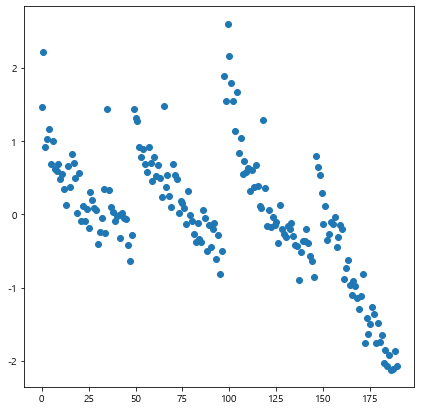

In [102]:
plt.figure(figsize = (7,7))
plt.scatter(y_hat_hat.index,y_hat)  # 잔차 그래프가 매우 상관성이 있어보인다..!
                                # 그룹 4개 상위 50개 4개년이라 그룹 형성!
plt.show()

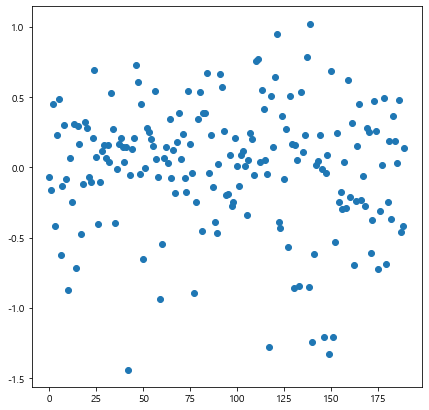

In [103]:
import random 

plt.figure(figsize = (7,7))
plt.scatter(range(len(y_hat_hat)),random.sample(list(y_hat_hat),len(y_hat_hat)))  
plt.show() # 순서 랜덤으로 하니 괜찮은 잔차 plot..!

Feature ranking
1. feature sqrt_actor_power (0.479)
2. feature log_youtube_view_mean (0.284)
3. feature sqrt_comment_count (0.163)
4. feature sqrt_abs_mean_score (0.075)


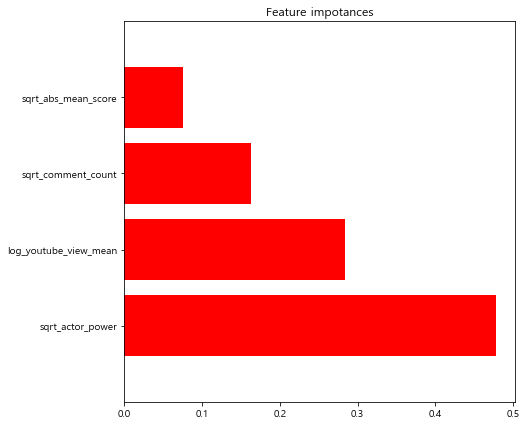

In [104]:
indices = np.argsort(importance)[::-1]

# print the feature ranking
print("Feature ranking")

# 상위 10개만
for f in range(4):
    print("{}. feature {} ({:.3f})".format(f+1, x_viral.columns[indices][f], importance[indices[f]]))
    
# Plot the imprity-based feature importances of the forest
plt.figure(figsize=(7,7))
plt.title("Feature impotances")
plt.barh(range(x_viral.shape[1]), importance[indices], color = 'r')
plt.yticks(range(x_viral.shape[1]), x_viral.columns[indices])
plt.ylim([-1, 4])
plt.show()

### Netflix Data

In [72]:
# modeling에 포함되지 않는 columns 제거
colums_rm = ['movie_name','release']
def remove_columns(movie_df):
    col = list(movie_df.columns)
    for i in colums_rm:
        col.remove(i)
    movie_df = movie_df.loc[:, col]
    
    return movie_df

In [73]:
netflix_df = pd.read_excel('C:/Users/User/Desktop/Viral_Effect/SNS-scraping/Netflix_Data.xlsx').iloc[:,1:]
netflix_df_tf = pd.read_excel('C:/Users/User/Desktop/Viral_Effect/SNS-scraping/Netflix_Data_transformation.xlsx').iloc[:,1:]

In [75]:
netflix_name = netflix_df.loc[:,'movie_name']

In [76]:
netflix_df = remove_columns(netflix_df)
netflix_df_tf = remove_columns(netflix_df_tf)

In [77]:
netflix_df

,youtube_view_mean,comment_count,abs_mean_score,actor_power
0,39636562.3,182052,0.877846,1837094.000
1,886085.3,3763,1.183902,6219299.667
2,1416440.5,10608,1.008533,3041107.333
3,260578.0,281,1.428533,547475.250
4,915003.6,10267,4.560011,1505560.000


In [78]:
netflix_df_tf

,log_youtube_view_mean,sqrt_comment_count,sqrt_abs_mean_score,sqrt_actor_power
0,17.495263,426.675521,0.936934,1355.394408
1,13.694569,61.343296,1.088073,2493.852375
2,14.163658,102.995146,1.004258,1743.877098
3,12.470658,16.763055,1.195213,739.915705
4,13.726683,101.326206,2.135418,1227.012632


In [79]:
modeling_df = netflix_df_tf.copy()

#### Forecasting

In [80]:
# 단위가 다르니 정규화 후 모델링
# Normalize Data
df_norm = modeling_df

std_scale = preprocessing.StandardScaler().fit(df_norm)
modeling_df_norm = std_scale.transform(df_norm)

#Converting numpy array to dataframe
modeling_df_norm_col = pd.DataFrame(modeling_df_norm, index=df_norm.index, columns=df_norm.columns) 
modeling_df.update(modeling_df_norm_col)
print (modeling_df.head())

   log_youtube_view_mean  sqrt_comment_count  sqrt_abs_mean_score  \
0               1.885398            1.952660            -0.761005   
1              -0.364399           -0.551666            -0.417716   
2              -0.086725           -0.266146            -0.608090   
3              -1.088886           -0.857261            -0.174364   
4              -0.345389           -0.277586             1.961175   

   sqrt_actor_power  
0         -0.267055  
1          1.674193  
2          0.395369  
3         -1.316541  
4         -0.485966  


In [89]:
netflix_pred = rf_fin.predict(modeling_df)
netflix_pred = pd.DataFrame(netflix_pred, columns = ['prediction'], index = list(netflix_name))
netflix_pred

,prediction
오징어 게임,0.807608
킹덤,0.118921
보건교사 안은영,0.120927
옥자,-1.317500
승리호,-0.161893


In [88]:
# y 값에 log 씌워서 예측 진행했으니 exp 적용
netflix_pred_exp = np.exp(netflix_pred)
netflix_pred_exp

,prediction
오징어 게임,2.242537
킹덤,1.126280
보건교사 안은영,1.128543
옥자,0.267804
승리호,0.850532


In [106]:
squidgame_pred_exp = netflix_pred_exp.loc['오징어 게임',]
squidgame_pred_exp

prediction    2.242537
Name: 오징어 게임, dtype: float64

## Viral Index

### Try

In [90]:
# 1) 최소 최대 기준으로 0~100
viral_index1 = netflix_pred_exp.apply(lambda x : (x-min(x))/(max(x) - min(x)) * 100)
viral_index1.columns = ['Viral_Index']
viral_index1

,Viral_Index
오징어 게임,100.000000
킹덤,43.473045
보건교사 안은영,43.587620
옥자,0.000000
승리호,29.509195


In [92]:
# 2) 오징어 게임을 100으로 
viral_index2 = netflix_pred_exp.apply(lambda x : (x/(max(x)) * 100))
viral_index2.columns = ['Viral_Index']
viral_index2

,Viral_Index
오징어 게임,100.000000
킹덤,50.223503
보건교사 안은영,50.324395
옥자,11.942017
승리호,37.927218


In [97]:
# 3) 정규화 (평균 0 , 분산 1로 조정)
std_scale = preprocessing.StandardScaler().fit(netflix_pred_exp)
netflix_pred_norm = std_scale.transform(netflix_pred_exp)
viral_index3 = pd.DataFrame(netflix_pred_norm*100, columns = ['Viral_index'], index = list(netflix_name))
viral_index3

,Viral_index
오징어 게임,174.437905
킹덤,0.489510
보건교사 안은영,0.842087
옥자,-133.288550
승리호,-42.480951


### Function

In [139]:
# modeling에 포함되지 않는 columns 제거
colums_rm = ['movie_name','release']
def remove_columns(movie_df):
    col = list(movie_df.columns)
    for i in colums_rm:
        col.remove(i)
    movie_df = movie_df.loc[:, col]
    
    return movie_df

In [140]:
# df : 'movie_name', 'release', 'log_youtube_view_mean', 'sqrt_comment_count', 'sqrt_abs_mean_score', 'sqrt_actor_power' 의 columns이 존재하는 DataFrame

def Viral_index(df):
    name = df.loc[:,'movie_name']
    df = remove_columns(df)
    
    # Normalize Data
    df_norm = df
    std_scale = preprocessing.StandardScaler().fit(df_norm)
    modeling_df_norm = std_scale.transform(df_norm)

    #Converting numpy array to dataframe
    modeling_df_norm_col = pd.DataFrame(modeling_df_norm, index=df_norm.index, columns=df_norm.columns) 
    df.update(modeling_df_norm_col)
    
    netflix_pred = rf_fin.predict(df)
    netflix_pred = pd.DataFrame(netflix_pred, columns = ['prediction'], index = list(name))
    netflix_pred_exp = np.exp(netflix_pred)
    
    viral_index = netflix_pred_exp.apply(lambda x : (x/squidgame_pred_exp.values) * 100)
    viral_index.columns = ['Viral_Index']

    return viral_index
   

In [141]:
netflix_df_tf_test = pd.read_excel('C:/Users/User/Desktop/Viral_Effect/SNS-scraping/Netflix_Data_transformation.xlsx').iloc[:,1:]
netflix_df_tf_test

,movie_name,release,log_youtube_view_mean,sqrt_comment_count,sqrt_abs_mean_score,sqrt_actor_power
0,오징어 게임,2021-09-17,17.495263,426.675521,0.936934,1355.394408
1,킹덤,2019-01-25,13.694569,61.343296,1.088073,2493.852375
2,보건교사 안은영,2020-09-25,14.163658,102.995146,1.004258,1743.877098
3,옥자,2017-05-19,12.470658,16.763055,1.195213,739.915705
4,승리호,2021-02-05,13.726683,101.326206,2.135418,1227.012632


In [142]:
Viral_index(netflix_df_tf_test)

,Viral_Index
오징어 게임,100.000000
킹덤,50.223503
보건교사 안은영,50.324395
옥자,11.942017
승리호,37.927218
